In [ ]:
"""
3D model

Data can be accessed on https://acdc.creatis.insa-lyon.fr/ 

How does it work?

IMPORTANT!
Please load the data in your folder by choice
and change the drive and data path correspondingly
in this block below

- run the blocks of code from top to bottom

"""
from google.colab import drive

# CHANGE DRIVE AND PATH HERE

drive.mount('/content/drive')
data_path = r'/content/drive/My Drive/Colab Notebooks/ACDC/training'

# Install some packages
!pip install monai
!pip install wandb
!pip install medpy

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 939 kB 5.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 5.1 MB/s 
     |████████████████████████████████| 181 kB 62.8 MB/s 
     |████████████████████████████████| 145 kB 67.9 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=def41759db4adc3463303e0ef86550933a490bd4dbf0baac3605e51930890ba6
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 151 kB 5.1 MB/s 
     |████████████████████████████████| 48.

In [ ]:
"""
This block contains all functions to be used in the running environment

"""

import os
from glob import glob
import time
import re
import argparse
import nibabel as nib
import pandas as pd
from medpy.metric.binary import hd, dc
import numpy as np
import matplotlib.pyplot as plt
import monai
from PIL import Image
import torch
from tqdm.notebook import tqdm
import wandb
from numpy import exp

HEADER = ["Name", "Dice LV", "Volume LV", "Err LV(ml)",
          "Dice RV", "Volume RV", "Err RV(ml)",
          "Dice MYO", "Volume MYO", "Err MYO(ml)"]

def build_heart_data(datapath,mode='train'):
  if mode not in ["train", "val", "test"]:
        raise ValueError(f"Please choose a mode in ['train', 'val', 'test']. Current mode is {mode}.")
  if mode=='train':
    range1=1
    range2=76
  elif mode=='val':
    range1=77
    range2=90
  elif mode=='test':
    range1=91
    range2=100

  # define empty dictionary
  dicts = []
  for number in range(range1,range2):
    patient='patient'+str(number).zfill(3)
    img_path=data_path+'/'+patient+'/' + patient+ '_frame01.nii.gz'
    mask_path=data_path+'/'+patient+'/' + patient+ '_frame01_gt.nii.gz'
    dicts.append({'img': img_path, 'mask': mask_path})
  return dicts

def from_compose_to_list(transform_compose):
    """
    Transform an object monai.transforms.Compose in a list fully describing the transform.
    /!\ Random seed is not saved, then reproducibility is not enabled.
    """
    from copy import deepcopy
        
    if not isinstance(transform_compose, monai.transforms.Compose):
        raise TypeError("transform_compose should be a monai.transforms.Compose object.")
    
    output_list = list()
    for transform in transform_compose.transforms:
        kwargs = deepcopy(vars(transform))
        
        # Remove attributes which are not arguments
        args = list(transform.__init__.__code__.co_varnames[1: transform.__init__.__code__.co_argcount])
        for key, obj in vars(transform).items():
            if key not in args:
                del kwargs[key]

        output_list.append({"class": transform.__class__, "kwargs": kwargs})
    return output_list


# calculate the softmax of a vector
def softmax(mask_output):
	e = exp(mask_output)
	return e / e.sum()
 

def wandb_masks(mask_output, mask_gt):
    """ Function that generates a mask dictionary in format that W&B requires """

    # Apply sigmoid to model ouput and round to nearest integer (0 or 1)
    #sigmoid = torch.nn.Sigmoid()
    #softmax = torch.nn.Softmax()
    mask_output = softmax(mask_output)
    mask_output = torch.round(mask_output)

    # Transform masks to numpy arrays on CPU
    # Note: .squeeze() removes all dimensions with a size of 1 (here, it makes the tensors 2-dimensional)
    # Note: .detach() removes a tensor from the computational graph to prevent gradient computation for it
    mask_output = mask_output.squeeze().detach().cpu().numpy()
    mask_gt = mask_gt.squeeze().detach().cpu().numpy()

    # Create mask dictionary with class label and insert masks
    class_labels = {1: 'Right ventricle', 2: 'Myocardium', 3: 'Left ventricle'}

    masks = {
        'predictions': {'mask_data': mask_output, 'class_labels': class_labels},
        'ground truth': {'mask_data': mask_gt, 'class_labels': class_labels}
    }
    return masks


def log_to_wandb(epoch, train_loss, val_loss, batch_data, outputs):
    """ Function that logs ongoing training variables to W&B """

    # Create list of images that have segmentation masks for model output and ground truth
    log_imgs = [wandb.Image(img, masks=wandb_masks(mask_output.detach().cpu(), mask_gt)) for img, mask_output,
                mask_gt in zip(batch_data['img'], outputs, batch_data['mask'])]

    # Send epoch, losses and images to W&B
    wandb.log({'epoch': epoch, 'train_loss': train_loss, 'val_loss': val_loss, 'results': log_imgs})
    #wandb.log({'epoch': epoch, 'train_loss': train_loss, 'val_loss': val_loss})
    
def visual_evaluation_3d(sample, model,slice):
    """
    Allow the visual inspection the result of one sample by plotting a slice
    of the 3D input.
    
    Args:
        sample (Dict[str, torch.Tensor]): sample composed of a 3D image ('img') and a mask ('mask').
        model (torch.nn.Module): trained model to evaluate.
        slice: slice number, an integer between 0 and 8

    Output: 2D slice of the ground truth and the prediction of the model
    """
    monai.utils.set_determinism(seed=0, additional_settings=None)
    model.eval()
    inferer = monai.inferers.SlidingWindowInferer(roi_size=[256,256,8])
    discrete_transform = monai.transforms.AsDiscrete(threshold=0.5)
    softmax = torch.nn.Softmax(dim=1)
    with torch.no_grad():
        output = discrete_transform(softmax(inferer(sample['img'].to(device), network=model).cpu()))
    
    fig, ax = plt.subplots(1,2, figsize = [10, 8]) 

  # Plot X-ray image
    ax[0].imshow(sample["img"][0,0,:,:,slice], 'gray')
    ax[1].imshow(sample['img'][0,0,:,:,slice], 'gray')
  # Plot ground truth
    colors = ['Purples','Blues','Greens']
    for i in range(3):
        mask = np.squeeze(sample['mask'][0, i+1, :,:,slice])
        overlay_mask = np.ma.masked_where(mask == 0, mask == 1)
        ax[0].imshow(overlay_mask, colors[i], alpha = 0.7, clim=[0,1], interpolation='nearest')          
        ax[0].set_title('Ground truth')
      # Plot output
        overlay_output = np.ma.masked_where(output[0, i+1, :,:,slice] < 0.5, output[0, i+1,:,:,slice] >0.5)
        ax[1].imshow(overlay_output, colors[i], alpha = 0.7, clim=[0,1])
        ax[1].set_title('Prediction')
    plt.show()

def compute_metric(dataloader, model, metric_fn):
    """
    This function computes the average value of a metric for a data set.
    
    Args:
        dataloader (monai.data.DataLoader): dataloader wrapping the dataset to evaluate.
        model (torch.nn.Module): trained model to evaluate.
        metric_fn (function): function computing the metric value from two tensors:
            - a batch of outputs,
            - the corresponding batch of ground truth masks.
        
    Returns:
        (float) the mean value of the metric
    """
    monai.utils.set_determinism(seed=0, additional_settings=None)
    model.eval()
    inferer = monai.inferers.SlidingWindowInferer(roi_size=[256,256,8])
    discrete_transform = monai.transforms.AsDiscrete(threshold=0.5)
    Sigmoid = torch.nn.Sigmoid()
    
    mean_value = 0

    for sample in dataloader:
        with torch.no_grad():
            output = discrete_transform(Sigmoid(inferer(sample['img'].to(device), network=model).cpu()))
        mean_value += metric_fn(output, sample["mask"],include_background=False)

    
    return (mean_value / (len(dataloader)))

def modeltrain(train_transform, epochs):
    """
    This function allows you to run a 3D U-NET
    Input: training data in 3D
    Output: model, 3D trained model
    """
    # apply transformations to training data
    train_dataset = monai.data.CacheDataset(train_dict_list, transform=train_transform)

    # create batches of training data of desired size
    train_loader = monai.data.DataLoader(train_dataset, batch_size=16, shuffle=True)

    # same procedure for validation data
    validation_dict = build_heart_data(data_path, mode='val')
    validation_data = monai.data.CacheDataset(validation_dict, transform=train_transform)
    validation_loader = monai.data.DataLoader(validation_data, batch_size=16)

    # connect to GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # create Unet
    model = monai.networks.nets.UNet(
        dimensions=3,
        in_channels=1, 
        out_channels=4, #labels
        channels = (16, 32, 64, 128), #how large the convolutions of each layer are
        strides=(2, 2, 2, 2),
        num_res_units=2,
    ).to(device)

    # define loss function
    loss_function =  monai.losses.DiceFocalLoss(softmax=True, batch=True)

    # define optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    # define run to connect to weights and biases
    run = wandb.init(
        project='ACDC',
        name='test',
        config={
            'loss function': str(loss_function), 
            'lr': optimizer.param_groups[0]["lr"],
            'transform': from_compose_to_list(train_transform),
            'batch_size': train_loader.batch_size,
        }
    )


    run_id = run.id # We remember here the run ID to be able to write the evaluation metrics

    # keep track of training loss and validation loss
    epochlist=[]
    train_loss_list = []
    val_loss_list = []
    for epoch in tqdm(range(epochs)):
        model.train()    
        epoch_loss = 0
        step = 0
        epochlist.append(epoch)
        for batch_data in train_loader: 
            step += 1
            optimizer.zero_grad()
            outputs = model(batch_data["img"].float().to(device))
            loss = loss_function(outputs, batch_data["mask"].to(device))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        train_loss = epoch_loss/step
        train_loss_list.append(train_loss)
        # validation part
        step = 0
        val_loss = 0
        for batch_data in validation_loader:
            step += 1
            model.eval()
            outputs = model(batch_data['img'].float().to(device))
            loss = loss_function(outputs, batch_data['mask'].to(device))
            val_loss+= loss.item()
        val_loss = val_loss / step
        val_loss_list.append(val_loss)
        #log_to_wandb(epoch, train_loss, val_loss, batch_data, outputs)


    # Store the network parameters        
    torch.save(model.state_dict(), r'trainedUNet.pt')
    run.finish()

    # print(epochlist)
    # print(train_loss_list)
    # print(val_loss_list)
    plt.plot(epochlist,val_loss_list)
    return model


Loading dataset: 100%|██████████| 13/13 [00:00<00:00, 32.17it/s]
/usr/local/lib/python3.7/dist-packages/monai/networks/nets/unet.py:139: UserWarning: `len(strides) > len(channels) - 1`, the last 1 values of strides will not be used.
  warnings.warn(f"`len(strides) > len(channels) - 1`, the last {delta} values of strides will not be used.")


  0%|          | 0/200 [00:00<?, ?it/s]

Loading dataset: 100%|██████████| 9/9 [00:00<00:00, 35.68it/s]


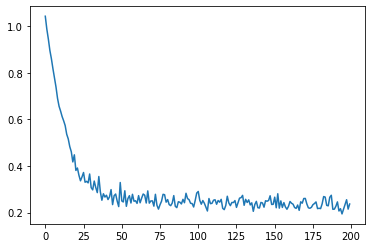

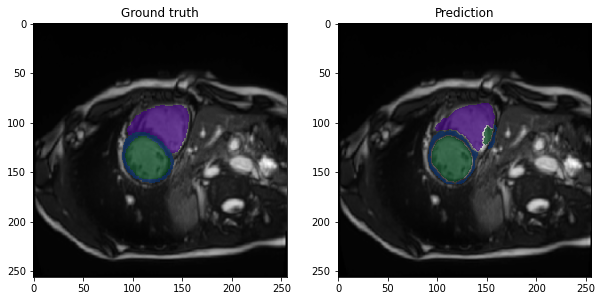

Dice on test set: 
 RV 0.76044106 
 MC 0.6093228 
 LV 0.69968814
Hausdorff distance on test set: 
 RV 99.7365319520423 
 MC 108.01205933912034 
 LV 114.88441157394128


In [ ]:
"""
Running environment

Run this block to get:

- validation loss graph
- sample 2D slice with ground truth and prediction from the 3D model
- Mean dice score
- Mean Hausdorff distance
"""
# make output deterministic for reproducibility
monai.utils.set_determinism(seed=0, additional_settings=None)
train_dict_list = build_heart_data(data_path, mode='train')
# transformations
train_transform = monai.transforms.Compose(
    [
        monai.transforms.LoadImaged(keys=['img', 'mask']),
        monai.transforms.AddChanneld(keys=['img', 'mask']),
        monai.transforms.RandSpatialCropd(keys=['img', 'mask'], roi_size=(256,256,8), random_size=False),
        monai.transforms.ScaleIntensityd(keys=['img'],minv=0, maxv=1),
        monai.transforms.AsDiscreted(keys = ['mask'], to_onehot=4),
        monai.transforms.Resized(keys = ['img','mask'],spatial_size=(256, 256,8), size_mode='all', mode=['area','nearest'], align_corners=None),
        ]
)
train_transform.set_random_state(seed=0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Change epochs to desired number of epochs
epochs = 200
model = modeltrain(train_transform, epochs)

# test data
test_dict = build_heart_data(data_path, mode='test')

# transformations
test_transform = monai.transforms.Compose([
        monai.transforms.LoadImaged(keys=['img', 'mask']),
        monai.transforms.AddChanneld(keys=['img', 'mask']),
        monai.transforms.RandSpatialCropd(keys=['img', 'mask'], roi_size=(256,256,8), random_size=False),
        monai.transforms.ScaleIntensityd(keys=['img'],minv=0, maxv=1),
        monai.transforms.AsDiscreted(keys = ['mask'], to_onehot=4),
        monai.transforms.Resized(keys = ['img','mask'],spatial_size=(256, 256,8), size_mode='all', mode=['area','nearest'], align_corners=None),
        ]
)
test_transform.set_random_state(seed=0)
test_set = monai.data.CacheDataset(test_dict, transform=test_transform)
test_loader = monai.data.DataLoader(test_set, batch_size=1)

# visualisation of the second slice of the first sample in the test set
for sample in test_loader:
    visual_evaluation_3d(sample, model,2)
    break

# compute metrics
metric_fn = monai.metrics.compute_meandice
dice = compute_metric(test_loader, model, metric_fn)
dice=dice.numpy()
print(f"Dice on test set: \r\n RV",dice[0][0],"\r\n MC",dice[0][1],"\r\n LV",dice[0][2])

metric_fn = monai.metrics.compute_hausdorff_distance
dice = compute_metric(test_loader, model, metric_fn)
dice=dice.numpy()
print(f"Hausdorff distance on test set: \r\n RV",dice[0][0],"\r\n MC",dice[0][1],"\r\n LV",dice[0][2])